**Week 3: Initial model_Lina**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U sentence-transformers scikit-learn datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import torch
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses, SentenceTransformerTrainingArguments
from torch.utils.data import DataLoader
from sentence_transformers import  InputExample, SentencesDataset
from sentence_transformers.losses import CoSENTLoss, ContrastiveLoss
from datasets import Dataset, DatasetDict

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
from google.colab import files
files.upload()

Saving updated_info_Lina.csv to updated_info_Lina.csv


{'updated_info_Lina.csv': b'\xef\xbb\xbfQuestion,Table_description ,label\r\nWhich schools require high school grades,This table contains data for branch campus locations from the 2022-23 IPEDS universe that were listed in College Navigator. This is not a comprehensive list of all Title IV branch campus locations in the U.S. and other jurisdictions. Main campus institutions that report to IPEDS have the option to list their branch campus locations in College Navigator. In the 2022-23 data collection; 191 main campus institutions reported a total of 504 branch locations. The number of provisionally released branch,1\r\nWhich schools require high school grades,This table contains the graduation rate status as of August 31; 2022; for the cohort of full-time; first-time degree or certificate-seeking undergraduates in both four-year and two-year institutions,1\r\nWhich schools require high school grades,This table contains information about the undergraduate selection process for entering f

In [ ]:
df = pd.read_csv('/content/updated_info_Lina.csv')

df.head()

,Question,Table_description,label
0,Which schools require high school grades,This table contains data for branch campus loc...,1
1,Which schools require high school grades,This table contains the graduation rate status...,1
2,Which schools require high school grades,This table contains information about the unde...,1
3,Which schools require high school grades,This table contains the number of programs off...,1
4,Which schools require high school grades,This table contains directory information for ...,0


In [ ]:
df.label.value_counts()


,count
label,
1,724
0,362


array([[<Axes: title={'center': 'label'}>]], dtype=object)

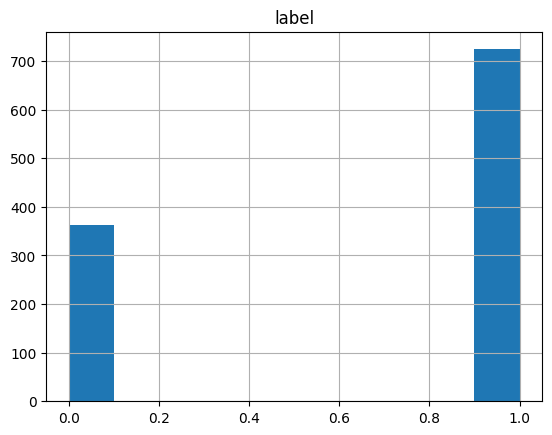

In [ ]:
df.hist()


In [ ]:
df.columns = df.columns.str.strip()


Initial Embeddings with msmarco-distilbert-base-v4

In [ ]:
#pretrained sentence transformer model
model = SentenceTransformer("msmarco-distilbert-base-v4") #MS MARCO for asymmetric semantic serach


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/319 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#define loss function model
loss = losses.ContrastiveLoss(model) #pairs of queries and positive negative table descriptions
##loss=losses.CosineSimilarityLoss(model)

In [ ]:
# Compute embeddings for both lists
embeddings1 = model.encode(df.Question)
embeddings2 = model.encode(df.Table_description)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = []

# Compute cosine similarity for each question and its corresponding table description
for i in range(len(df)):
    # Compute cosine similarity between question i and its corresponding table description i
    similarity = cosine_similarity([embeddings1[i]], [embeddings2[i]])[0][0]
    # Append the similarity to the list
    cosine_similarities.append(similarity)

# Add the cosine similarity scores as a new column in the dataframe
df['before_training_cosine_similarity'] = cosine_similarities

df.head()

,Question,Table_description,label,before_training_cosine_similarity
0,Which schools require high school grades,This table contains data for branch campus loc...,1,0.116113
1,Which schools require high school grades,This table contains the graduation rate status...,1,0.125867
2,Which schools require high school grades,This table contains information about the unde...,1,0.157409
3,Which schools require high school grades,This table contains the number of programs off...,1,0.186237
4,Which schools require high school grades,This table contains directory information for ...,0,0.033013


In [ ]:
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="/content/MyDrive/embedding_question2context",

    # Training parameters:
    num_train_epochs=15,  # Set to 15 epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if GPU can't handle FP16

    # Change to epoch-based strategies:
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save at the end of each epoch

    # Additional parameters for saving the best model:
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="eval_loss",  # Based on which metric to save the best model

    # Logging parameters:
    logging_strategy="epoch",  # Log at the end of each epoch
    save_total_limit=2,  # Limit to 2 saved models to avoid storage issues

    # Run name (optional, for tracking purposes):
    run_name="mpnet-base-all-nli-triplet",  # Used in W&B if wandb is installed
)

In [ ]:
from sklearn.model_selection import train_test_split
from sentence_transformers import InputExample

# Assuming df has a 'label' column that we want to stratify on
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Prepare train and validation examples
train_examples = []
val_examples = []

# Create InputExample objects for the training set
for _, row in train_df.iterrows():
    train_examples.append(InputExample(texts=[row['Question'], row['Table_description']], label=row['label']))

# Create InputExample objects for the validation set
for _, row in val_df.iterrows():
    val_examples.append(InputExample(texts=[row['Question'], row['Table_description']], label=row['label']))

# Now train_examples and val_examples are ready for use in training


array([[<Axes: title={'center': 'label'}>,
        <Axes: title={'center': 'before_training_cosine_similarity'}>]],
      dtype=object)

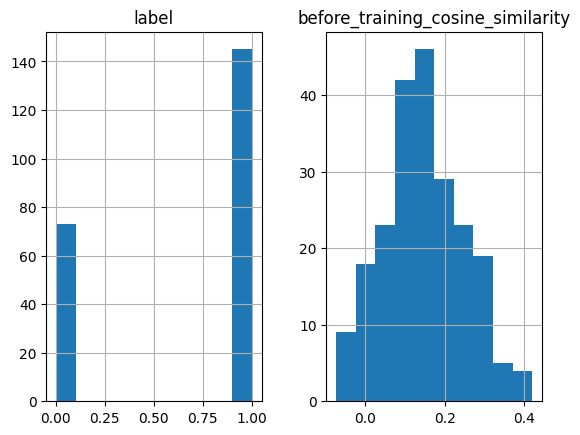

In [ ]:
val_df.hist()

array([[<Axes: title={'center': 'label'}>,
        <Axes: title={'center': 'before_training_cosine_similarity'}>]],
      dtype=object)

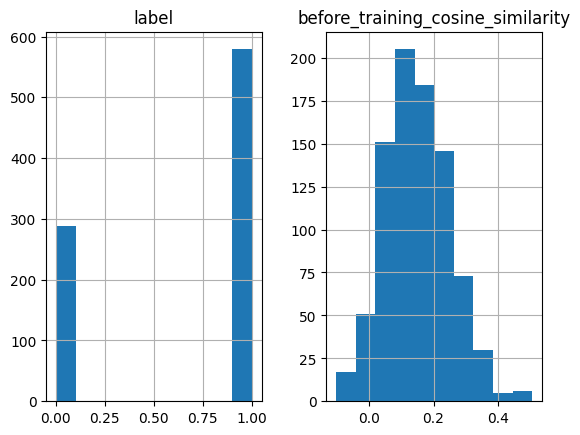

In [ ]:
train_df.hist()


In [ ]:
def example_to_dict(example):
    return{
        'sentence1': example.texts[0],
        'sentence2': example.texts[1],
        'label': example.label
    }

# Create dictionaries from examples
train_dict = {
    'sentence1': [ex.texts[0] for ex in train_examples],
    'sentence2': [ex.texts[1] for ex in train_examples],
    'label': [ex.label for ex in train_examples]
}

eval_dict = {
    'sentence1': [ex.texts[0] for ex in val_examples],
    'sentence2': [ex.texts[1] for ex in val_examples],
    'label': [ex.label for ex in val_examples]
}

# Create Dataset objects
train_dataset = Dataset.from_dict(train_dict)
eval_dataset = Dataset.from_dict(eval_dict)

# Wrap with DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "eval": eval_dataset
})

In [ ]:
dataset



DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 868
    })
    eval: Dataset({
        features: ['sentence1', 'sentence2', 'label'],
        num_rows: 218
    })
})

In [ ]:
dataset["train"][1]




{'sentence1': 'What is the average number of months to complete the largest program offered by institutions in Texas?',
 'sentence2': 'This table contains the graduation rate status as of August 31; 2022; for the cohort of full-time; first-time degree or certificate-seeking undergraduates in both four-year and two-year institutions',
 'label': 1}

In [ ]:
import wandb

# Disable WandB logging
wandb.init(mode='disabled')

In [ ]:
trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset= train_dataset,
    loss=loss,
    args=args,
    eval_dataset= eval_dataset
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.076300,0.017397
2,0.016500,0.014158
3,0.014200,0.013704
4,0.011500,0.012074
5,0.010000,0.014946
6,0.008600,0.013488
7,0.007400,0.012186
8,0.006400,0.012123
9,0.006500,0.012640
10,0.005800,0.012268


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

TrainOutput(global_step=825, training_loss=0.012619567387031787, metrics={'train_runtime': 297.0851, 'train_samples_per_second': 43.826, 'train_steps_per_second': 2.777, 'total_flos': 0.0, 'train_loss': 0.012619567387031787, 'epoch': 15.0})

In [ ]:
# Evaluate the model
evaluation_results = trainer.evaluate()

# Print evaluation results
print("Evaluation Results:", evaluation_results)

# Save the model
output_dir = "/content/MyDrive/embedding_question2context"
trainer.save_model(output_dir)

# Optionally, save tokenizer and configuration if needed
model.save_pretrained(output_dir)

Evaluation Results: {'eval_loss': 0.01207420602440834, 'eval_runtime': 0.4514, 'eval_samples_per_second': 482.973, 'eval_steps_per_second': 31.017, 'epoch': 15.0}


In [ ]:
# Compute embeddings for both lists
embeddings1 = model.encode(df.Question)
embeddings2 = model.encode(df.Table_description)

In [ ]:
cosine_similarities = []

# Compute cosine similarity for each question and its corresponding table description
for i in range(len(df)):
    # Compute cosine similarity between question i and its corresponding table description i
    similarity = cosine_similarity([embeddings1[i]], [embeddings2[i]])[0][0]
    # Append the similarity to the list
    cosine_similarities.append(similarity)

# Add the cosine similarity scores as a new column in the dataframe
df['after_training_cosine_similarity'] = cosine_similarities

df.head(6)

,Question,Table_description,label,before_training_cosine_similarity,after_training_cosine_similarity
0,Which schools require high school grades,This table contains data for branch campus loc...,1,0.116113,0.953320
1,Which schools require high school grades,This table contains the graduation rate status...,1,0.125867,0.949745
2,Which schools require high school grades,This table contains information about the unde...,1,0.157409,0.965414
3,Which schools require high school grades,This table contains the number of programs off...,1,0.186237,0.937719
4,Which schools require high school grades,This table contains directory information for ...,0,0.033013,0.597090
5,Which schools require high school grades,This table contains the unduplicated headcount...,0,0.153246,0.485387


array([[<Axes: title={'center': 'label'}>,
        <Axes: title={'center': 'before_training_cosine_similarity'}>],
       [<Axes: title={'center': 'after_training_cosine_similarity'}>,
        <Axes: >]], dtype=object)

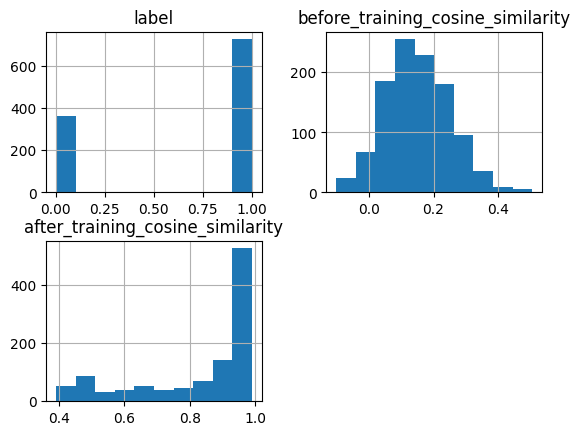

In [ ]:
df.hist()


In [ ]:
df['predict'] = df['after_training_cosine_similarity'].apply(lambda x: 1 if x > 0.9 else 0)


In [ ]:
df.head()


,Question,Table_description,label,before_training_cosine_similarity,after_training_cosine_similarity,predict
0,Which schools require high school grades,This table contains data for branch campus loc...,1,0.116113,0.953320,1
1,Which schools require high school grades,This table contains the graduation rate status...,1,0.125867,0.949745,1
2,Which schools require high school grades,This table contains information about the unde...,1,0.157409,0.965414,1
3,Which schools require high school grades,This table contains the number of programs off...,1,0.186237,0.937719,1
4,Which schools require high school grades,This table contains directory information for ...,0,0.033013,0.597090,0


In [ ]:
#Calculate accuracy
accuracy = (df['label'] == df['predict']).mean()

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.45%


In [ ]:
df.to_csv('df.csv', index=False)



In [ ]:
from google.colab import files
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Week 4: Trying different models _lina**


In [ ]:
#Trying different models

# List of model names
model_names = ["msmarco-MiniLM-L-6-v3", "msmarco-MiniLM-L-12-v3", "all-mpnet-base-v2", "msmarco-roberta-base-v3", "multi-qa-MiniLM-L6-cos-v1"]
results = []

#k_values=[1, 2, 3, 4, 5, 6]  # K values for accuracy calculation

for model_name in model_names:
    # load the model
    model = SentenceTransformer(model_name)

    # Define the loss function
    loss = losses.ContrastiveLoss(model)

    # Compute embeddings and cosine similarity before training
    embeddings1 = model.encode(df.Question)
    embeddings2 = model.encode(df.Table_description)
    cosine_similarities_before = []

     # Compute cosine similarity for each question and its corresponding table description
    for i in range(len(df)):
     # Compute cosine similarity between question i and its corresponding table description i
        similarity = cosine_similarity([embeddings1[i]], [embeddings2[i]])[0][0]
     # Append the similarity to the list
        cosine_similarities_before.append(similarity)
    # Add cosine similarity before training to DataFrame
    df[f'before_training_cosine_similarity_{model_name}'] = cosine_similarities_before#.diagonal()

    # Create a trainer with training arguments
    args = SentenceTransformerTrainingArguments(
        output_dir=f"/content/MyDrive/embedding_question2context_{model_name}",
        num_train_epochs=15,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_ratio=0.1,
        fp16=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        logging_strategy="epoch",
        save_total_limit=2,
        run_name=model_name,
    )

    trainer = SentenceTransformerTrainer(
        model=model,
        train_dataset=train_dataset,
        loss=loss,
        args=args,
        eval_dataset=eval_dataset
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    evaluation_results = trainer.evaluate()
    print(f"Evaluation Results for {model_name}: {evaluation_results}")

    # Save the model
    model.save_pretrained(f"/content/MyDrive/embedding_question2context_{model_name}")


    # get embeddings after training, and calculate cosine similarity after training
    embeddings1 = model.encode(df.Question)
    embeddings2 = model.encode(df.Table_description)

    cosine_similarities_after = []
    for i in range(len(df)):
        similarity = cosine_similarity([embeddings1[i]], [embeddings2[i]])[0][0]
        cosine_similarities_after.append(similarity)
    #Add cosine similarity after training to DataFrame
    df[f'after_training_cosine_similarity_{model_name}'] = cosine_similarities_after

    # Generate predictions with a threshold of 0.9
    df[f'predicted_label_{model_name}'] = df[f'after_training_cosine_similarity_{model_name}'].apply(lambda x: 1 if x > 0.9 else 0)

    # Calculate overall accuracy
    accuracy = (df['label'] == df[f'predicted_label_{model_name}']).mean()
    print(f'Accuracy for {model_name} at 0.9: {accuracy * 100:.2f}%')

    # Store results in list
    results.append({
        'model_name': model_name,
        'evaluation_results': evaluation_results,
        'overall_accuracy': accuracy,
        'df': df[[ 'Question', 'Table_description', 'label', f'predicted_label_{model_name}', f'before_training_cosine_similarity_{model_name}', f'after_training_cosine_similarity_{model_name}']],
    })

# Optionally convert results to a DataFrame for further analysis
final_results_df = pd.concat([result['df'] for result in results], keys=[result['model_name'] for result in results])

# Output the final DataFrame
print(final_results_df)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.077400,0.019028
2,0.017200,0.015184
3,0.015100,0.015211
4,0.013300,0.013325
5,0.012000,0.016337
6,0.010800,0.016450
7,0.009900,0.013536
8,0.008600,0.014270
9,0.008400,0.013376
10,0.007600,0.012791


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Evaluation Results for msmarco-MiniLM-L-6-v3: {'eval_loss': 0.012543764896690845, 'eval_runtime': 0.3551, 'eval_samples_per_second': 613.945, 'eval_steps_per_second': 39.428, 'epoch': 15.0}
Accuracy for msmarco-MiniLM-L-6-v3 at 0.9: 84.25%


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.067900,0.017711
2,0.015900,0.014232
3,0.014300,0.014655
4,0.011600,0.013450
5,0.010600,0.014585
6,0.008800,0.014374
7,0.007500,0.012454
8,0.006500,0.012525
9,0.006600,0.012501
10,0.006200,0.011777


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Evaluation Results for msmarco-MiniLM-L-12-v3: {'eval_loss': 0.011604377999901772, 'eval_runtime': 0.6811, 'eval_samples_per_second': 320.08, 'eval_steps_per_second': 20.556, 'epoch': 15.0}
Accuracy for msmarco-MiniLM-L-12-v3 at 0.9: 88.86%


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.043600,0.017674
2,0.015200,0.014406
3,0.014500,0.015424
4,0.011800,0.013941
5,0.011200,0.016859
6,0.009100,0.014313
7,0.007500,0.012104
8,0.006600,0.012590
9,0.006500,0.011668
10,0.005800,0.012698


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Evaluation Results for all-mpnet-base-v2: {'eval_loss': 0.01166802179068327, 'eval_runtime': 0.7894, 'eval_samples_per_second': 276.165, 'eval_steps_per_second': 17.735, 'epoch': 15.0}
Accuracy for all-mpnet-base-v2 at 0.9: 86.28%


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.070600,0.015506
2,0.015500,0.013924
3,0.014300,0.014099
4,0.011500,0.012156
5,0.009900,0.013728
6,0.008200,0.012747
7,0.007100,0.011358
8,0.006100,0.012434
9,0.006700,0.011526
10,0.005800,0.012611


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Evaluation Results for msmarco-roberta-base-v3: {'eval_loss': 0.011357813142240047, 'eval_runtime': 0.7515, 'eval_samples_per_second': 290.105, 'eval_steps_per_second': 18.631, 'epoch': 15.0}
Accuracy for msmarco-roberta-base-v3 at 0.9: 84.35%


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.065000,0.020326
2,0.015900,0.014267
3,0.014600,0.015008
4,0.013400,0.013807
5,0.012500,0.014660
6,0.010900,0.013759
7,0.009700,0.013841
8,0.008500,0.013573
9,0.008300,0.012847
10,0.007500,0.012845


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Evaluation Results for multi-qa-MiniLM-L6-cos-v1: {'eval_loss': 0.01221416611224413, 'eval_runtime': 0.487, 'eval_samples_per_second': 447.622, 'eval_steps_per_second': 28.746, 'epoch': 15.0}
Accuracy for multi-qa-MiniLM-L6-cos-v1 at 0.9: 86.56%
                                                                    Question  \
msmarco-MiniLM-L-6-v3     0         Which schools require high school grades   
                          1         Which schools require high school grades   
                          2         Which schools require high school grades   
                          3         Which schools require high school grades   
                          4         Which schools require high school grades   
...                                                                      ...   
multi-qa-MiniLM-L6-cos-v1 1081  How many universites have graduate offerings   
                          1082  How many universites have graduate offerings   
                          1083  Ho

In [ ]:
final_results_df # the dataframe for all models

Question  \
msmarco-MiniLM-L-6-v3     0         Which schools require high school grades   
                          1         Which schools require high school grades   
                          2         Which schools require high school grades   
                          3         Which schools require high school grades   
                          4         Which schools require high school grades   
...                                                                      ...   
multi-qa-MiniLM-L6-cos-v1 1081  How many universites have graduate offerings   
                          1082  How many universites have graduate offerings   
                          1083  How many universites have graduate offerings   
                          1084  How many universites have graduate offerings   
                          1085  How many universites have graduate offerings   

                                                                Table_description  \
msmarco-MiniLM-L-6-v3     0     This table contains data for branch campus loc...   
                          1     This table contains the graduation rate status...   
                          2     This table contains information about the unde...   
                          3     This table contains the number of programs off...   
                          4     This table contains directory information for ...   
...                                                                           ...   
multi-qa-MiniLM-L6-cos-v1 1081  This table contains the graduation rate status...   
                          1082  This table contains information about the unde...   
                          1083  This table contains the number of programs off...   
                          1084  This table contains directory information for ...   
                          1085  This table contains the unduplicated headcount...   

                                label  predicted_label_msmarco-MiniLM-L-6-v3  \
msmarco-MiniLM-L-6-v3     0         1                                    1.0   
                          1         1                                    1.0   
                          2         1                                    1.0   
                          3         1                                    1.0   
                          4         0                                    0.0   
...                               ...                                    ...   
multi-qa-MiniLM-L6-cos-v1 1081      1                                    NaN   
                          1082      1                                    NaN   
                          1083      1                                    NaN   
                          1084      0                                    NaN   
                          1085      0                                    NaN   

                                before_training_cosine_similarity_msmarco-MiniLM-L-6-v3  \
msmarco-MiniLM-L-6-v3     0                                              0.247621         
                          1                                              0.194327         
                          2                                              0.234558         
                          3                                              0.274788         
                          4                                              0.132684         
...                                                                           ...         
multi-qa-MiniLM-L6-cos-v1 1081                                                NaN         
                          1082                                                NaN         
                          1083                                                NaN         
                          1084                                                NaN         
                          1085                                                NaN         

                                

In [ ]:
specific_model_df = final_results_df.xs('multi-qa-MiniLM-L6-cos-v1', level=0)
specific_model_df # showing the dataframe with before and after cosine similarity , question, table description, actual and
#predicted label for specific model

,Question,Table_description,label,predicted_label_msmarco-MiniLM-L-6-v3,before_training_cosine_similarity_msmarco-MiniLM-L-6-v3,after_training_cosine_similarity_msmarco-MiniLM-L-6-v3,predicted_label_msmarco-MiniLM-L-12-v3,before_training_cosine_similarity_msmarco-MiniLM-L-12-v3,after_training_cosine_similarity_msmarco-MiniLM-L-12-v3,predicted_label_all-mpnet-base-v2,before_training_cosine_similarity_all-mpnet-base-v2,after_training_cosine_similarity_all-mpnet-base-v2,predicted_label_msmarco-roberta-base-v3,before_training_cosine_similarity_msmarco-roberta-base-v3,after_training_cosine_similarity_msmarco-roberta-base-v3,predicted_label_multi-qa-MiniLM-L6-cos-v1,before_training_cosine_similarity_multi-qa-MiniLM-L6-cos-v1,after_training_cosine_similarity_multi-qa-MiniLM-L6-cos-v1
0,Which schools require high school grades,This table contains data for branch campus loc...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.198457,0.931162
1,Which schools require high school grades,This table contains the graduation rate status...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.255679,0.915649
2,Which schools require high school grades,This table contains information about the unde...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.314080,0.933785
3,Which schools require high school grades,This table contains the number of programs off...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.341858,0.939529
4,Which schools require high school grades,This table contains directory information for ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.230635,0.505103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,How many universites have graduate offerings,This table contains the graduation rate status...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.494387,0.941981
1082,How many universites have graduate offerings,This table contains information about the unde...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.315165,0.952908
1083,How many universites have graduate offerings,This table contains the number of programs off...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.428008,0.928682
1084,How many universites have graduate offerings,This table contains directory information for ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.357873,0.562892


In [ ]:
specific_model_df = final_results_df.xs('msmarco-MiniLM-L-6-v3', level=0)
specific_model_df

,Question,Table_description,label,predicted_label_msmarco-MiniLM-L-6-v3,before_training_cosine_similarity_msmarco-MiniLM-L-6-v3,after_training_cosine_similarity_msmarco-MiniLM-L-6-v3,predicted_label_msmarco-MiniLM-L-12-v3,before_training_cosine_similarity_msmarco-MiniLM-L-12-v3,after_training_cosine_similarity_msmarco-MiniLM-L-12-v3,predicted_label_all-mpnet-base-v2,before_training_cosine_similarity_all-mpnet-base-v2,after_training_cosine_similarity_all-mpnet-base-v2,predicted_label_msmarco-roberta-base-v3,before_training_cosine_similarity_msmarco-roberta-base-v3,after_training_cosine_similarity_msmarco-roberta-base-v3,predicted_label_multi-qa-MiniLM-L6-cos-v1,before_training_cosine_similarity_multi-qa-MiniLM-L6-cos-v1,after_training_cosine_similarity_multi-qa-MiniLM-L6-cos-v1
0,Which schools require high school grades,This table contains data for branch campus loc...,1,1.0,0.247621,0.921796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Which schools require high school grades,This table contains the graduation rate status...,1,1.0,0.194327,0.916835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Which schools require high school grades,This table contains information about the unde...,1,1.0,0.234558,0.931741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Which schools require high school grades,This table contains the number of programs off...,1,1.0,0.274788,0.937801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Which schools require high school grades,This table contains directory information for ...,0,0.0,0.132684,0.473368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,How many universites have graduate offerings,This table contains the graduation rate status...,1,1.0,0.384077,0.938116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082,How many universites have graduate offerings,This table contains information about the unde...,1,1.0,0.268823,0.947611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1083,How many universites have graduate offerings,This table contains the number of programs off...,1,1.0,0.405365,0.935437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1084,How many universites have graduate offerings,This table contains directory information for ...,0,0.0,0.307108,0.520427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
L_12_model_df = final_results_df.xs('msmarco-MiniLM-L-12-v3', level=0)
L_12_model_df

,Question,Table_description,label,predicted_label_msmarco-MiniLM-L-6-v3,before_training_cosine_similarity_msmarco-MiniLM-L-6-v3,after_training_cosine_similarity_msmarco-MiniLM-L-6-v3,predicted_label_msmarco-MiniLM-L-12-v3,before_training_cosine_similarity_msmarco-MiniLM-L-12-v3,after_training_cosine_similarity_msmarco-MiniLM-L-12-v3,predicted_label_all-mpnet-base-v2,before_training_cosine_similarity_all-mpnet-base-v2,after_training_cosine_similarity_all-mpnet-base-v2,predicted_label_msmarco-roberta-base-v3,before_training_cosine_similarity_msmarco-roberta-base-v3,after_training_cosine_similarity_msmarco-roberta-base-v3,predicted_label_multi-qa-MiniLM-L6-cos-v1,before_training_cosine_similarity_multi-qa-MiniLM-L6-cos-v1,after_training_cosine_similarity_multi-qa-MiniLM-L6-cos-v1
0,Which schools require high school grades,This table contains data for branch campus loc...,1,NaN,NaN,NaN,1.0,0.245882,0.943834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Which schools require high school grades,This table contains the graduation rate status...,1,NaN,NaN,NaN,1.0,0.222258,0.939935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Which schools require high school grades,This table contains information about the unde...,1,NaN,NaN,NaN,1.0,0.218799,0.958582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Which schools require high school grades,This table contains the number of programs off...,1,NaN,NaN,NaN,1.0,0.185432,0.947343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Which schools require high school grades,This table contains directory information for ...,0,NaN,NaN,NaN,0.0,0.142905,0.546196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,How many universites have graduate offerings,This table contains the graduation rate status...,1,NaN,NaN,NaN,1.0,0.454018,0.928332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082,How many universites have graduate offerings,This table contains information about the unde...,1,NaN,NaN,NaN,1.0,0.276563,0.945100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1083,How many universites have graduate offerings,This table contains the number of programs off...,1,NaN,NaN,NaN,1.0,0.326550,0.967085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1084,How many universites have graduate offerings,This table contains directory information for ...,0,NaN,NaN,NaN,0.0,0.328566,0.516485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
specific_model_df = final_results_df.xs('all-mpnet-base-v2', level=0)
specific_model_df

,Question,Table_description,label,predicted_label_msmarco-MiniLM-L-6-v3,before_training_cosine_similarity_msmarco-MiniLM-L-6-v3,after_training_cosine_similarity_msmarco-MiniLM-L-6-v3,predicted_label_msmarco-MiniLM-L-12-v3,before_training_cosine_similarity_msmarco-MiniLM-L-12-v3,after_training_cosine_similarity_msmarco-MiniLM-L-12-v3,predicted_label_all-mpnet-base-v2,before_training_cosine_similarity_all-mpnet-base-v2,after_training_cosine_similarity_all-mpnet-base-v2,predicted_label_msmarco-roberta-base-v3,before_training_cosine_similarity_msmarco-roberta-base-v3,after_training_cosine_similarity_msmarco-roberta-base-v3,predicted_label_multi-qa-MiniLM-L6-cos-v1,before_training_cosine_similarity_multi-qa-MiniLM-L6-cos-v1,after_training_cosine_similarity_multi-qa-MiniLM-L6-cos-v1
0,Which schools require high school grades,This table contains data for branch campus loc...,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.286694,0.933428,NaN,NaN,NaN,NaN,NaN,NaN
1,Which schools require high school grades,This table contains the graduation rate status...,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.220493,0.955707,NaN,NaN,NaN,NaN,NaN,NaN
2,Which schools require high school grades,This table contains information about the unde...,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.318718,0.943595,NaN,NaN,NaN,NaN,NaN,NaN
3,Which schools require high school grades,This table contains the number of programs off...,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.366542,0.945968,NaN,NaN,NaN,NaN,NaN,NaN
4,Which schools require high school grades,This table contains directory information for ...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.303883,0.493902,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,How many universites have graduate offerings,This table contains the graduation rate status...,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.393429,0.957942,NaN,NaN,NaN,NaN,NaN,NaN
1082,How many universites have graduate offerings,This table contains information about the unde...,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.284456,0.945482,NaN,NaN,NaN,NaN,NaN,NaN
1083,How many universites have graduate offerings,This table contains the number of programs off...,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.402641,0.961883,NaN,NaN,NaN,NaN,NaN,NaN
1084,How many universites have graduate offerings,This table contains directory information for ...,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.416801,0.491526,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
!zip -r /content/MyDrive/embedding_question2context_L_12.zip /content/MyDrive/embedding_question2context_L_12


Measure the accuracy by checking how many relevant tables the model predicts for a given question. focus on the top K documents with the highest cosine similarity scores and evaluate the accuracy at different values of K ( K=1, K=3, K=5, K=6).

**Week 5 Task 1_Lina**


In [ ]:
from sklearn.metrics import confusion_matrix # msmarco_distilbert-base-v4

# Generate confusion matrix
tn, fp, fn, tp = confusion_matrix(df['label'], df['predict']).ravel()

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Precision-msmarco_distilbert-base-v4: {precision*100:.2f}%')
print(f'Recall-msmarco_distilbert-base-v4: {recall*100:.2f}%')
print(f'F1 Score-msmarco_distilbert-base-v4: {f1_score*100:.2f}%')

Precision-msmarco_distilbert-base-v4: 95.50%
Recall-msmarco_distilbert-base-v4: 82.04%
F1 Score-msmarco_distilbert-base-v4: 88.26%


In [ ]:
# Generate confusion matrix #msmarco-MiniLM-L-12-v3
tn, fp, fn, tp = confusion_matrix(L_12_model_df['label'], L_12_model_df['predicted_label_msmarco-MiniLM-L-12-v3']).ravel()

# Calculate precision, recall, and F1 score
precision_2 = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_2 = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score_2 = 2 * (precision_2 * recall_2) / (precision_2 + recall_2) if (precision_2 + recall_2) > 0 else 0

print(f'Precision-msmarco-MiniLM-L-12-v3: {precision_2*100:.2f}%')
print(f'Recall-msmarco-MiniLM-L-12-v3: {recall_2*100:.2f}%')
print(f'F1 Score-msmarco-MiniLM-L-12-v3: {f1_score_2*100:.2f}%')

Precision-msmarco-MiniLM-L-12-v3: 97.18%
Recall-msmarco-MiniLM-L-12-v3: 85.77%
F1 Score-msmarco-MiniLM-L-12-v3: 91.12%


In [ ]:

##testing accuracy with the model: msmarco-distilbert-base-v4

k_values=[1, 2, 3, 4, 5, 6]
# Function to calculate accuracy at different values of K
def calculate_accuracy_at_k(df, k_values):
    results = []

    # Iterate over unique questions
    for question in df['Question'].unique():
        question_rows = df[df['Question'] == question]

        # Sort tables by after_training_cosine_similarity in descending order
        question_rows_sorted = question_rows.sort_values(by='after_training_cosine_similarity', ascending=False)

        # Relevant tables (where label == 1)
        relevant_table = set(question_rows_sorted[question_rows_sorted['label'] == 1]['Table_description'])

        # Calculate accuracy for different K values
        accuracy_at_k = {}
        for k in k_values:
            # Get the top K tables based on predicted cosine similarity
            top_k_tables = set(question_rows_sorted.head(k)['Table_description'])

            # Calculate intersection of top K and ground truth
            correct_predictions= len(list(table for table in relevant_table if table in top_k_tables))
            total_relevant = len(relevant_table)

            if total_relevant > 0:
                accuracy = correct_predictions / total_relevant
            else:
                accuracy = 0

            accuracy_at_k[k] = accuracy

        results.append({
            'question': question,
            'relevant_table': relevant_table,
            'accuracy_at_k': accuracy_at_k
        })

    return results

# Calculate accuracy for different K values
k_values = [1, 2, 3, 4, 5, 6]
results = calculate_accuracy_at_k(df, k_values)

# Print ground truth and accuracy for each question
for result in results:

    print(f"Question: {result['question']}")
    print(f"Relevant tables: {result['relevant_table']}")
    for k in k_values:
        print(f"Accuracy at K={k}: {result['accuracy_at_k'][k]:.2f}")
    print("\n")

# Calculate total accuracy at each K value across all questions
total_accuracy_at_k = {k: 0 for k in k_values}
for result in results:
    for k in k_values:
        total_accuracy_at_k[k] += result['accuracy_at_k'][k]

# Average the total accuracy over the number of questions
num_questions = len(df['Question'].unique())
for k in k_values:
    total_accuracy_at_k[k] /= num_questions

print("Total Accuracy at different K values:")
for k in k_values:
    print(f"Total Accuracy at K={k}: {total_accuracy_at_k[k]*100:.2f}%")


Question: Which schools require high school grades
Relevant tables: {'This table contains the graduation rate status as of August 31; 2022; for the cohort of full-time; first-time degree or certificate-seeking undergraduates in both four-year and two-year institutions', 'This table contains data for branch campus locations from the 2022-23 IPEDS universe that were listed in College Navigator. This is not a comprehensive list of all Title IV branch campus locations in the U.S. and other jurisdictions. Main campus institutions that report to IPEDS have the option to list their branch campus locations in College Navigator. In the 2022-23 data collection; 191 main campus institutions reported a total of 504 branch locations. The number of provisionally released branch', 'This table contains the number of programs offered by type of program; level of award (certificate or degree); and distance education status. Type of program is categorized according to the 2020 Classification of Instructi

In [ ]:
#testing accuracy with the model: msmarco-MiniLM-L-12-v3

k_values=[1, 2, 3, 4, 5, 6]
# Function to calculate accuracy at different values of K
def calculate_accuracy_at_k(L_12_model_df, k_values):
    results = []

    # Iterate over unique questions
    for question in df['Question'].unique():
        question_rows = df[df['Question'] == question]

        # Sort tables by after_training_cosine_similarity in descending order
        question_rows_sorted = question_rows.sort_values(by='after_training_cosine_similarity_msmarco-MiniLM-L-12-v3', ascending=False)

        # Relevant tables (where label == 1)
        relevant_table = set(question_rows_sorted[question_rows_sorted['label'] == 1]['Table_description'])

        # Calculate accuracy for different K values
        accuracy_at_k = {}
        for k in k_values:
            # Get the top K tables based on predicted cosine similarity
            top_k_tables = set(question_rows_sorted.head(k)['Table_description'])

            # Calculate intersection of top K and ground truth
            #correct_predictions = len(top_k_tables.intersection(ground_truth))
            correct_predictions= len(list(table for table in relevant_table if table in top_k_tables))
            total_relevant = len(relevant_table)

            if total_relevant > 0:
                accuracy = correct_predictions / total_relevant
            else:
                accuracy = 0

            accuracy_at_k[k] = accuracy

        results.append({
            'question': question,
            'relevant_table': relevant_table,
            'accuracy_at_k': accuracy_at_k
        })

    return results

# Calculate accuracy for different K values
k_values = [1, 2, 3, 4, 5, 6]
results = calculate_accuracy_at_k(df, k_values)

# Print ground truth and accuracy for each question
for result in results:

    print(f"Question: {result['question']}")
    print(f"Relevant tables: {result['relevant_table']}")
    for k in k_values:
        print(f"Accuracy at K={k}: {result['accuracy_at_k'][k]:.2f}")
    print("\n")

# Calculate total accuracy at each K value across all questions
total_accuracy_at_k = {k: 0 for k in k_values}
for result in results:
    for k in k_values:
        total_accuracy_at_k[k] += result['accuracy_at_k'][k]

# Average the total accuracy over the number of questions
num_questions = len(df['Question'].unique())
for k in k_values:
    total_accuracy_at_k[k] /= num_questions

print("Total Accuracy at different K values:")
for k in k_values:
    print(f"Total Accuracy at K={k}: {total_accuracy_at_k[k]*100:.2f}%")


Question: Which schools require high school grades
Relevant tables: {'This table contains the graduation rate status as of August 31; 2022; for the cohort of full-time; first-time degree or certificate-seeking undergraduates in both four-year and two-year institutions', 'This table contains data for branch campus locations from the 2022-23 IPEDS universe that were listed in College Navigator. This is not a comprehensive list of all Title IV branch campus locations in the U.S. and other jurisdictions. Main campus institutions that report to IPEDS have the option to list their branch campus locations in College Navigator. In the 2022-23 data collection; 191 main campus institutions reported a total of 504 branch locations. The number of provisionally released branch', 'This table contains the number of programs offered by type of program; level of award (certificate or degree); and distance education status. Type of program is categorized according to the 2020 Classification of Instructi


Measure the accuracy by checking how many relevant tables the model predicts for a given question. focus on the top K documents with the highest cosine similarity scores and evaluate the accuracy at different values of K ( K=1, K=3, K=5, K=6).

**Week 5 Task 1_Ruoxi**


In [ ]:
model = SentenceTransformer("/content/MyDrive/embedding_question2context")

In [ ]:
df_unique = df.drop_duplicates(subset=['Table_description'])

In [ ]:
df_unique['Table_description_embedding'] = df_unique['Table_description'].apply(lambda x: model.encode(x, convert_to_tensor=True))


In [ ]:
import torch

In [ ]:
def search_top_k(query, k, df_unique, model):
    # Encode the query into a tensor of embeddings using the model.
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Stack all embeddings from 'Table_description_embedding' into a single tensor.
    table_desc_embeddings = torch.stack(df_unique['Table_description_embedding'].tolist())

    # Compute cosine similarity between the query embedding and all table description embeddings.
    similarity_scores = torch.nn.functional.cosine_similarity(query_embedding, table_desc_embeddings)

    # Retrieve the top 'k' values and their indices based on the cosine similarity scores.
    scores, indices = torch.topk(similarity_scores, k=k)

    # Initialize an empty list to store the results.
    results = []

    # Iterate over each score and corresponding index.
    for score, idx in zip(scores, indices):
        # Append a dictionary with the table description and its cosine similarity score to the results list.
        # 'idx.item()' converts the tensor to a regular integer index.
        results.append({"Table_description": df_unique.iloc[idx.item()]["Table_description"], "score": score.item()})

    # Convert the results list to a DataFrame and return.
    return pd.DataFrame(results)


In [ ]:
# Define the query and number of results to retrieve
query = 'How many universities in boston city?'
k = 4

# Assuming 'search_top_k' function and 'model' are defined, and 'df_unique' is prepared
top_k_results = search_top_k(query, k, df_unique, model)

# Print the top k results
print(top_k_results)


In [ ]:
df[(df["Question"] == query) & (df["label"] == 1)]


In [ ]:
def evaluate_model_accuracy(df, df_unique, model, k):
    # Get unique questions from df
    unique_questions = df['Question'].unique()
    total_accuracy = 0
    total_questions = 0

    # Loop over each unique question
    for question in unique_questions:
        # Get ground truth table descriptions for this question
        ground_truth_tables = df[(df['Question'] == question) & (df["label"] == 1)]['Table_description'].tolist()

        if not ground_truth_tables:
            continue

        total_questions += 1

        # Perform search to get top k table descriptions for this question
        top_k_results = search_top_k(question, k, df_unique, model)

        # Extract the table descriptions from the results
        found_tables = top_k_results['Table_description'].tolist()

        # Count how many ground truth tables were found in the top k results
        matches = len([table for table in found_tables if table in ground_truth_tables])

        # Calculate accuracy for this question (matches / total ground truth tables)
        if len(ground_truth_tables) > 0:
            accuracy = matches / len(ground_truth_tables)
        else:
            accuracy = 0

        total_accuracy += accuracy

        # Print the results for this question
        print(f"Question: {question}")
        print(f"Accuracy: {accuracy:.2%} ({matches} / {len(ground_truth_tables)}) ground truth tables matched.")
        print()

    # Calculate and print overall accuracy
    if total_questions > 0:
        overall_accuracy = total_accuracy / total_questions
    else:
        overall_accuracy = 0

    print(f"Overall accuracy: {overall_accuracy:.2%}")

In [ ]:
k = 4
df_unique_val = df_unique.drop_duplicates(subset=['Table_description'])
overall_accuracy = evaluate_model_accuracy(df, df_unique_val, model, k)


In [ ]:
def evaluate_model_accuracies(df, df_unique, model, K_values):
    unique_questions = df['Question'].unique()
    accuracies = {k: [] for k in K_values}  # Dictionary to store accuracies for each K

    for question in unique_questions:
        ground_truth_tables = df[(df['Question'] == question) & (df["label"] == 1)]['Table_description'].tolist()
        if not ground_truth_tables:
            continue

        for k in K_values:
            top_k_results = search_top_k(question, k, df_unique, model)
            found_tables = top_k_results['Table_description'].tolist()
            matches = len([table for table in found_tables if table in ground_truth_tables])
            accuracy = matches / len(ground_truth_tables) if ground_truth_tables else 0
            accuracies[k].append(accuracy)  # Append the accuracy for this K

    overall_accuracies = {k: sum(accuracies[k]) / len(accuracies[k]) if accuracies[k] else 0 for k in K_values}
    return overall_accuracies


In [ ]:
k_values = [1, 3, 4, 5, 6]
df_unique_val = df_unique.drop_duplicates(subset=['Table_description'])

# Evaluate accuracies for different K values
accuracies_for_ks = evaluate_model_accuracies(df, df_unique_val, model, k_values)

# Print the accuracies for each K value
for k, acc in accuracies_for_ks.items():
    print(f"Accuracy for K={k}: {acc:.2%}")


In [ ]:
# Zip the model in Colab
!zip -r /content/model.zip /content/MyDrive/embedding_question2context

In [ ]:
from google.colab import files
files.download('/content/model.zip')
